# Some Dense OF Algorithms

File structure
```shell
- misc
    - *.py
    - *.ipynb
    - mav_datasets
```


In [1]:
import cv2 as cv
import numpy as np
import glob
import time
from matplotlib import pyplot as plt
import os

img_folder = './mav_datasets/cyberzoo_poles_panels_mats/20190121-142935/'
img_files = glob.glob(img_folder + '*.jpg')
img_files.sort()
imgs = []
for fn in img_files:
    imgs.append(cv.imread(fn))

farneback_folder = './mav_datasets/cyberzoo_poles_panels_mats/farneback/'
dis_folder = './mav_datasets/cyberzoo_poles_panels_mats/dis/'


In [2]:
camera_matrix = np.array(
    [[323.30439544,   0.       ,  264.1811044],
    [  0.         ,323.73762591, 213.45702275],
    [  0.         ,  0.        ,   1.        ]]
)
distortion = np.array([-3.42172094e-01,  1.42618962e-01,  6.17475602e-05,  1.79552857e-04, -3.15633611e-02])
h, w = imgs[0].shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(camera_matrix, distortion, (w, h), 0, (w, h))
x0, y0, dx, dy = roi
imgs_rectified = []
imgs_rectified_gray = []

for img in imgs:
    rectified = cv.undistort(img, camera_matrix, distortion, None, newcameramtx)
    gray = cv.cvtColor(rectified, cv.COLOR_BGR2GRAY)
    blur = cv.medianBlur(gray, 5)
    imgs_rectified.append(rectified)
    imgs_rectified_gray.append(gray)


imgs_for_flow = imgs_rectified_gray

## Farneback

In [3]:
flow_farneback = []
img_count = len(imgs_for_flow)
start_time = time.time()
for i in range(img_count - 1):
    img_this = imgs_for_flow[i]
    img_next = imgs_for_flow[i + 1]
    flow = cv.calcOpticalFlowFarneback(img_this, img_next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flow_farneback.append(flow)
stop_time = time.time()
runtime_farneback = stop_time - start_time
avg_runtime_farneback = runtime_farneback/(img_count - 1)
print(runtime_farneback, avg_runtime_farneback, 1/avg_runtime_farneback, flow_farneback[0].shape)

os.system('rm -rf ' + farneback_folder)
os.system('mkdir -p ' + farneback_folder)
vis_farneback = []
i = 0
for flow in flow_farneback:
    mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
    hsv = np.zeros_like(imgs[0])
    hsv[..., 1] = 255
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    cv.imwrite(farneback_folder + str(i) + '.jpg', bgr)
    vis_farneback.append(bgr)
    i += 1

11.820631742477417 0.025096882680419146 39.84558611258165 (240, 520, 2)


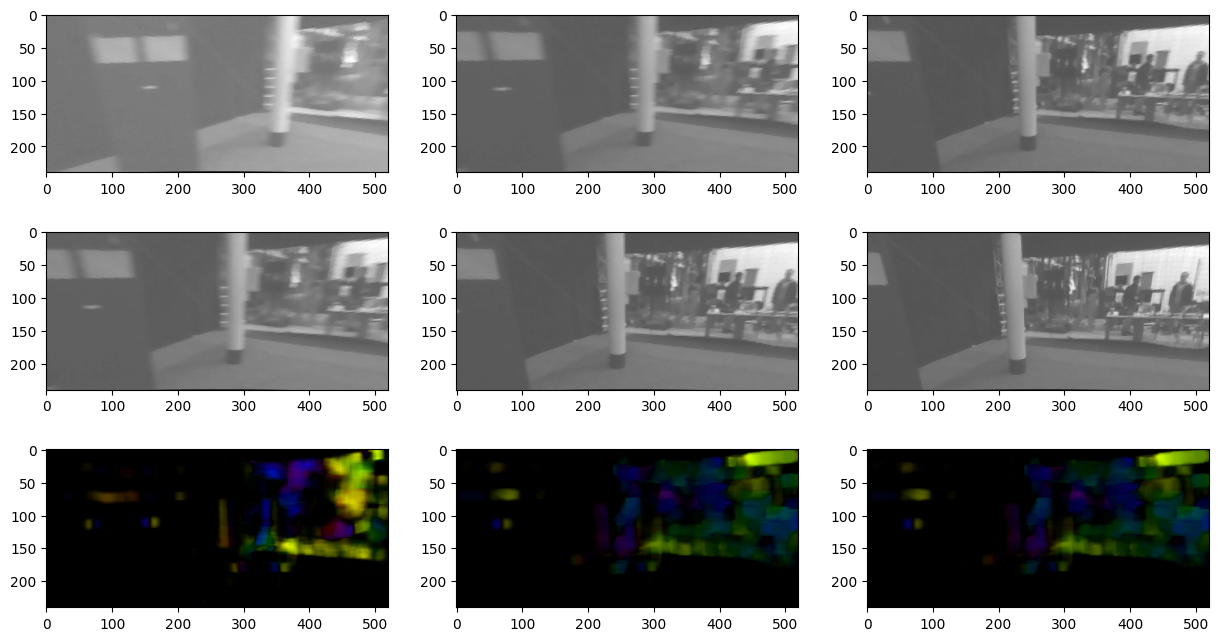

In [4]:
i = 176
plt.figure(figsize=(15, 8))
plt.subplot(3, 3, 1)
plt.imshow(imgs_for_flow[i], cmap='gray')
plt.subplot(3, 3, 2)
plt.imshow(imgs_for_flow[i + 1], cmap='gray')
plt.subplot(3, 3, 3)
plt.imshow(imgs_for_flow[i + 2], cmap='gray')
plt.subplot(3, 3, 4)
plt.imshow(imgs_for_flow[i + 1], cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(imgs_for_flow[i + 2], cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(imgs_for_flow[i + 3], cmap='gray')
plt.subplot(3, 3, 7)
plt.imshow(vis_farneback[i])
plt.subplot(3, 3, 8)
plt.imshow(vis_farneback[i + 1])
plt.subplot(3, 3, 9)
plt.imshow(vis_farneback[i + 1])


## `opt_flow_test.py`

Results from https://github.com/ylchan87/OpticalFlow_Test

| Algo | FPS |
| ---- | ----|
|"DIS_Medium"   |  30|
|"DIS_Fast"     | 120|
|"DIS_UltraFast"| 200|
|"Farneback"    |   4.5|
|"DenseRLOF"    |   2|
|"DualTVL1"     |   0.2|
|"PCAFlow"      |  10|
|"DeepFlow"     |   1|

Farneback only detects "dense" OF at edges or texture rich objects. DenseRLOF, PCAFLOW, DIS all detect more global OF. PCA and DIS run significantly faster, and DenseRLOF runs slightly slower than Farneback while providing much denser information.

| Algo | FPS 1T | FPS 1 | FPS 16T | FPS 16
| ---- | ----| ---- | ----| ---- |
| PCA | > 30 | > 30 | > 30 | > 30 |
| DIS | > 80 | > 90 | > 150 | > 200 |


In [5]:
img_array = []
for filename in img_files:
    img = cv.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
out = cv.VideoWriter(img_folder + '../video.avi',cv.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()